(ch:center)=
# Centering

This part will teach you:

1. Basic ways to find the centroid (center of mass) position using few methods.

First, read [this photutils/centroids tutorial](https://photutils.readthedocs.io/en/stable/centroids.html) and [this photutils/detection tutorial](https://photutils.readthedocs.io/en/stable/detection.html). Follow the tutorials before starting this lecture note.

In [1]:
# Ignore this cell if you encounter errors
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-04-19 16:30:54 (KST = GMT+0900) 
0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.7.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 photutils  1.6.1.dev103+gad22185f
8 version_information 1.0.4


In [15]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy.time import Time
from astropy import units as u
from astropy.nddata import CCDData, Cutout2D
from astropy.stats import sigma_clipped_stats

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.centroids import centroid_com

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

## Prepare Data
* Cut the image with [``astropy.nddata.Cutout2D``](https://docs.astropy.org/en/stable/api/astropy.nddata.utils.Cutout2D.html).
* I cut the image centered at ``position=(270, 320)`` and size of ``size=(100, 100)`` pixels.

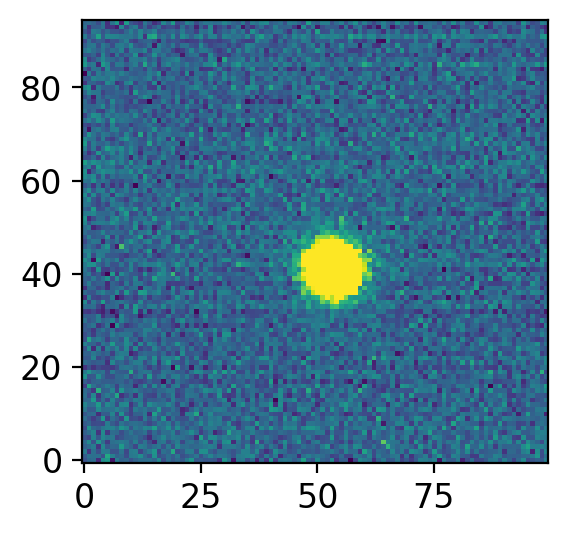

In [9]:
allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

hdul = fits.open(allfits[0])
hdr = hdul[0].header
data = hdul[0].data
cut_hdu = Cutout2D(data=data, position=(270,320), size=(95,100))

fig, axs = plt.subplots(1, 1, figsize=(3, 4), sharex=False, sharey=False, gridspec_kw=None)
vis.norm_imshow(axs, cut_hdu.data, zscale=True)
plt.tight_layout()

## Finding Centroid

There are multiple practical ways to find the center of an object. Here, I will introduce four simplest ways.

1. The center-of-mass of the image.
2. Using Gaussian function.
3. Find the center by DAOPHOT-like algorithm (see below)
4. Find the center by SExtractor-like algorithm (see below)

The center of mass is easy to calculate, but in python, `scipy` provides a simple function [`center_of_mass`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.center_of_mass.html). In astronomical images, people will just use [`photutils.centroids.centroid_com`](https://photutils.readthedocs.io/en/stable/api/photutils.centroids.centroid_com.html#photutils.centroids.centroid_com).

To fit Gaussian function to the image, there are several ways to do this. First, decide whether you want a circular Gaussian (4 parameters = x-center, y-center, amplitude, sigma), or an elliptical Gaussian (6 parameters = same as circular case except sigma_x, sigma_y, theta). Then you can directly fit 2-D Gaussian to the image. When background level is non-zero, you need one more constant parameter.

Due to the mathematical characteristic of Gaussian function, you can also prove this: Say $I(x, y) = G_x(x | \mu_x, \sigma_x) \times G_y(y | \mu_y, \sigma_y)$. Here $G_x$ and $G_y$ are the Gaussian fitting results for the image is summed along the y- and x-direction, respectively. $\mu$ and $\sigma$ are the center and standard deviation of fitted Gaussians, respectively. For example, $G_x(x| \mu_x, \sigma_y)$ is the fitted Gaussian to data $D(x) = \sum_{y=1}{N_y} D(x, y)$. Then $I(x, y)$ is a Gaussian with center $(\mu_x, \mu_y)$. This holds true only if $\mathrm{min} \{I\} = 0$ is guaranteed, which is usually not the case in real images.

For several reasons, Gaussian fitting is not always the best choice.

DAOPHOT algorithm is that described in [Stetson 1987](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract) and you have already used it in photutils/detection tutorial. This is basically used when you are dealing with **circular stars**.  If you are studying extended sources (nebula, galaxy, non-sidereal objects, etc), it may not work properly.

SExtractor-like algorithm is basically used to detect general objects and also has power to calculate proper/useful center information. You will study this later in extended sources lecture note.


### Simple Center-of-Mass
Consider you want to find the center of mass of the star in the cropped image above. This is acutally not an easy task, because real data is contaminated by cosmic-rays, defects (dead pixels, hot pixels, ...), background objects, uneven sky, etc.

To improve the robustness of center-of-mass, I here used the most elementary level algorithm I could think of.
* Do sigma-clipping to the cutout data. Get statistics of the clipped data.
* Set the threshold as median plus 3-sigma.
* Get centroid by center of mass algorithm using only the pixels above that threshold level.

[53.09601482 41.04309313]


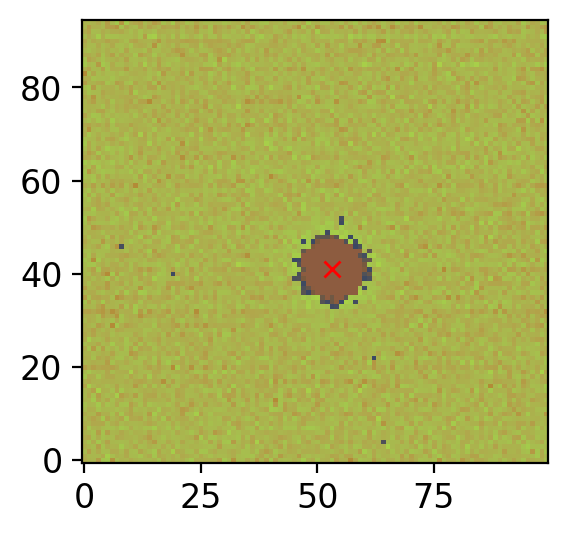

In [18]:
avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.
thresh_3sig = med + 3 * std
mask_3sig = (cut_hdu.data < thresh_3sig)
center = centroid_com(data=cut_hdu.data, mask=mask_3sig)
print(center)

fig, axs = plt.subplots(1, 1, figsize=(3, 4), sharex=False, sharey=False, gridspec_kw=None)
vis.norm_imshow(axs, mask_3sig.astype(int))
vis.norm_imshow(axs, cut_hdu.data, alpha=0.4, zscale=True)
axs.plot(*center, 'rx')
plt.tight_layout()

In the code, I overplotted the image onto the ``mask_3sig``. The faint background-like feature is the original image, and the highlight means the pixels used for the centroid calculation. Red cross is the thus found centroid.


```{admonition} Practice
:class: tip
In realistic centroiding, this method **should not be used**. This is becasue virtually all of the photometric information is contained in only very small area around the true center, so we need to do centroiding using, e.g., ``cbox`` (shorthand for centroiding box) size of $\sim$ 1-3 FWHM to minimize error sources. What you have to do is to cutout only a small region near the center of the object and do centroiding. This is not an easy task to realize, so it is better to use pre-made functions.

Consider you have to know the center of mass of this object (e.g., you cannot use Gaussian fitting, DAOPHOT, etc). How would you calculate it **robustly**? Give at least three possible algorithms/methods/improvements you can think of. Possible hints: You can use `mask`, bad-pixel rejection/interpolation, etc. You may have an idea which of them will work best only after you encounter an enormous amount of real data...
```